In [222]:
import time
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm

In [132]:
def normal_dist(x, mean = 0, std = 1):
    return np.exp(-1/2*((x-mean)/std)**2)/(std*np.sqrt(2*np.pi))
class Poly:
    def __init__(self, shape, order = [1, 2], activate = None, mean = 0, std = 1):
        # input: (batch, input_size)
        # output: (batch, input_size)
        # shape: (intput_size, node_size)
        # kernel = (node_size,)
        self.weights = ['std', 'mean', 'order', 'shape', 'name']
        self.name = 'Poly'
        def normal_dist(x, mean = 0, std = 1):
            return np.exp(-1/2*((x-mean)/std)**2)/(std*np.sqrt(2*np.pi))
        self.shape = shape
        self.input_size = shape[0]
        self.node_size = shape[-1]
        self.kernel_shape = (shape[-1],)
        # self.w = np.random.normal(0, std, (shape[-1],) )
        self.mean = np.random.normal(mean, std, (shape[-1],) )
        self.std = np.ones((shape[-1],))*std
        self.order = np.random.uniform(order[0], order[1], (shape[-1],) )
        self.norm = normal_dist
        if activate == None:
            def fn(x):
                return x
            self.activate = fn
        else:
            self.activate = activate
            
    def random_decent(self, x, lr = 1e-4):
        # x: (batch_size, input_size)
        self.batch_size = x.shape[0]
        self.Lo = np.random.uniform(-1, 1, self.kernel_shape)
        self.Lm = np.random.uniform(-1, 1, 1)
        self.Ls = np.random.uniform(-1, 1, 1)
        m = self.mean - lr*self.Lm
        s = self.std - lr*self.Ls
        o = np.tile(np.expand_dims(self.order-lr*self.Lo, axis = [0,1]), [self.batch_size, self.input_size, 1])
        x = np.expand_dims(x, axis = -1)
        x = np.tile(x, [1,1,self.node_size])
        dist = self.norm(o, mean = m, std = s)
        norm = np.expand_dims(np.sum(dist, axis = -1), axis = -1)
        return np.mean(dist/(norm)*(x**o), axis = -1)
    
    def update_weights(self, lr = 1e-4):
        self.mean = self.mean - lr*self.Lm
        self.std = self.std - lr*self.Ls
        # self.w = self.w - lr*self.Lw
        self.order = self.order - lr*self.Lo
    def call(self, x):
        self.batch_size = x.shape[0]
        o = np.tile(np.expand_dims(self.order, axis = [0,1]), [self.batch_size, self.input_size, 1])
        x = np.expand_dims(x, axis = -1)
        x = np.tile(x, [1,1,self.node_size])
        dist = self.norm(o, mean = self.mean, std = self.std)
        norm = np.expand_dims(np.sum(dist, axis = -1), axis = -1)
        return np.mean(dist/(norm)*(x**o), axis = -1) 

In [7]:
np.expand_dims(np.array([1,2]), axis = [0,1])

array([[[1, 2]]])

In [133]:
def relu(x):
    return (x>=0)*x
class Linear:
    def __init__(self, shape, activate = None):
        # shape:(output_size, input_size)
        self.weights = ['w', 'b', 'shape', 'name']
        self.shape = shape
        self.w = np.random.normal(0, 1, shape)
        self.b = np.zeros((shape[0]))
        self.name = 'Linear'
        if activate == None:
            def fn(x):
                return x
            self.activate = fn
        else:
            self.activate = activate
    def random_decent(self, x, lr = 1e-4):
        # x: (batch_size, input_size)
        self.batch_size = x.shape[0]
        self.Lw = np.random.uniform(-1, 1, self.shape)
        self.bLw = np.tile(np.expand_dims(self.Lw, axis = 0), [self.batch_size, 1, 1])
        self.Lb = np.random.uniform(-1, 1, self.b.shape)
        self.bLb = np.tile(np.expand_dims(self.Lb, axis = 0), [self.batch_size, 1])
        w =  np.tile(np.expand_dims(self.w, axis = 0), [self.batch_size, 1, 1])
        b = np.tile(np.expand_dims(self.b, axis = 0), [self.batch_size, 1])
        x = np.expand_dims(x, axis = -1)
        return np.matmul(w - lr*self.bLw, x)[:, :, 0] + (b - lr*self.bLb)
    def update_weights(self, lr = 1e-4):
        self.w = self.w - lr*self.Lw
        self.b = self.b - lr*self.Lb
    def call(self, x):
        self.batch_size = x.shape[0]
        w =  np.tile(np.expand_dims(self.w, axis = 0), [self.batch_size, 1, 1])
        b = np.tile(np.expand_dims(self.b, axis = 0), [self.batch_size, 1])
        x = np.expand_dims(x, axis = -1)
        return np.matmul(w, x)[:, :, 0] + b
        
class Model:
    def __init__(self, inputs, outputs):
        self.HiddenLayers = []
        self.Inputs = inputs
        self.Outputs = outputs
        self.index = np.arange(0, inputs.shape[0], 1)
        self.loss_fn = self.MSE
        self.test_layer = -1
        self.history = {'epoch':[], 'Loss':[]}
    def add_layer(self, layer):
        self.HiddenLayers.append(layer)
    def predict(self, x):
        for i, l in enumerate(self.HiddenLayers):
            if i == self.test_layer:
                x = l.random_decent(x, lr = self.lr)
            else:
                x = l.call(x)
        return x
    def MSE(self, y_tar, y_pre):
        # y pre/tar : (batch_size, output_size)
        return np.mean((y_pre-y_tar)**2)
    def loss(self, x, y):
        y_pre = self.predict(x)
        return self.loss_fn(y, y_pre)
    def shuffle(self,):
        # index = np.arange(0, self.Inputs.shape[0], 1)
        np.random.shuffle(self.index)
        x = self.Inputs[self.index]
        N = int(len(x)/self.batch_size)
        x = x[:N*self.batch_size]
        x = np.reshape(x, (N, self.batch_size,)+x[0].shape)
        y = self.Outputs[self.index]
        y = y[:N*self.batch_size]
        y = np.reshape(y, (N, self.batch_size,)+y[0].shape)
        self.N = N
        return x, y
    def training(self, batch_size = 32, lr = 1e-4, random_times = 100):
        self.batch_size = batch_size
        self.lr = lr
        x, y = self.shuffle()
        for e in range(self.N):
        #N: number of epoches
            self.test_layer = -1
            L = self.loss(x[e], y[e])
            for i, l in enumerate(self.HiddenLayers):
                for rds in range(random_times):
                    self.test_layer = i
                    Ltest = self.loss(x[e], y[e])
                    if Ltest < L:
                        l.update_weights(lr = lr)
                        L = Ltest
            self.test_layer = -1
            self.history['epoch'].append(e)
            self.history['Loss'].append(L)
            # print("epoch{}, Loss{}".format(e, L))
    def save_weights(self, path = './model/'):
        import os
        import pickle
        if not os.path.isdir(path):
            os.mkdir(path)
        app = dict()
        app['num_of_layer'] = len(self.HiddenLayers)
        for i, l in enumerate(self.HiddenLayers):
            for wn in l.weights:
                key = 'Layer_{}_{}'.format(i, wn)
                exec("app[key] = l.{}".format(wn))
        with open(path+'Weights.plk', 'wb') as f:
            pickle.dump(app, f)
    def load_weights(self, path = './model/'):
        import pickle
        with open(path+'Weights.plk', 'rb') as f:
            app = pickle.load(f)
            for i, l in enumerate(self.HiddenLayers):
                for wn in l.weights:
                    key = 'Layer_{}_{}'.format(i, wn)
                    exec("l.{} = app[key]".format(wn))


In [196]:
def stdz(x):
    x = (x-np.mean(x))/np.std(x)
    x = x-np.min(x)+1e-3
    return x

In [150]:
df = pd.read_csv('./Walmart.csv')

In [154]:
df.keys()

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [239]:
# df['Date'] = df['Date'].map(lambda x: datetime.datetime.strptime(x, "%d-%m-%Y"))
df['Month'] = df['Date'].map(lambda x: x.month)
df['Day'] = df['Date'].map(lambda x: x.day)
df['Year'] = df['Date'].map(lambda x: x.year)
df['WeekOfYear'] = df['Date'].map(lambda x: x.isocalendar()[1])

In [241]:
keys = ['Store', 'Holiday_Flag', 'Temperature','Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Day', 'Year', 'WeekOfYear']
STDK = ['Temperature','Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Day', 'Year', 'WeekOfYear']
x = []
for k in keys:
    x.append(list(stdz(np.array(df[k]))))

In [242]:
x = np.array(x)
# y = np.array(df['Weekly_Sales'].map(float) )
y = np.array(stdz(np.array(df['Weekly_Sales'].map(float))))

x = x.T
# x = np.expand_dims(x, axis = -1)
y = np.expand_dims(y, axis = -1)

In [245]:
x.shape

(6435, 10)

In [243]:
y.shape

(6435, 1)

In [252]:
# N = 2000
# x = np.abs(np.random.uniform(10, 3, (N, 10)))
# w = np.abs(np.random.uniform(10, 1, (2,10)))
# w = np.expand_dims(w, axis = 0)
# w = np.tile(w, [N, 1, 1])
# y = np.random.uniform(10, 1, (100, 2))
# y = np.matmul(w, np.expand_dims(x**2, axis = -1))[:,:,0]



model = Model(x, y)
model.add_layer(Poly((10, 10)))
model.add_layer(Linear((16, 10), activate = relu))
model.add_layer(Linear((32, 16), activate = relu))
model.add_layer(Linear((1, 32)))
n_print = 1
# for i in range(100):
#     time_start = time.time()
#     model.training(batch_size = 32, lr = 1e-4, random_times = 100)
#     if i%n_print == 0:
#         print("Step:{}, Loss:{}, Time:{}".format(i, model.history['Loss'][-1], time.time()-time_start ))
#         time_start = time.time()
        


In [253]:
batch_size = 100
for i in range(20):
    time_start = time.time()
    model.training(batch_size = batch_size, lr = 3e-2, random_times = 100)
    if i%n_print == 0:
        print("Step:{}, Loss:{}, Time:{}".format(i, model.history['Loss'][-1], time.time()-time_start ))
        time_start = time.time()
for i in range(20, 50):
    time_start = time.time()
    model.training(batch_size = batch_size, lr = 1e-2, random_times = 100)
    if i%n_print == 0:
        print("Step:{}, Loss:{}, Time:{}".format(i, model.history['Loss'][-1], time.time()-time_start ))
        time_start = time.time()
for i in range(50, 100):
    time_start = time.time()
    model.training(batch_size = batch_size, lr = 1e-3, random_times = 100)
    if i%n_print == 0:
        print("Step:{}, Loss:{}, Time:{}".format(i, model.history['Loss'][-1], time.time()-time_start ))
        time_start = time.time()
for i in range(100, 150):
    time_start = time.time()
    model.training(batch_size = batch_size, lr = 1e-4, random_times = 100)
    if i%n_print == 0:
        print("Step:{}, Loss:{}, Time:{}".format(i, model.history['Loss'][-1], time.time()-time_start ))
        time_start = time.time()
# for i in range(150, 200):
#     time_start = time.time()
#     model.training(batch_size = batch_size, lr = 1e-5, random_times = 100)
#     if i%n_print == 0:
#         print("Step:{}, Loss:{}, Time:{}".format(i, model.history['Loss'][-1], time.time()-time_start ))
#         time_start = time.time()


Step:0, Loss:0.844687577645939, Time:19.25924825668335
Step:1, Loss:0.6563637663277438, Time:17.015128135681152
Step:2, Loss:0.7133778117397729, Time:16.62636423110962
Step:3, Loss:0.8555980093100074, Time:16.767651319503784
Step:4, Loss:0.8609591091211897, Time:16.619155645370483
Step:5, Loss:0.8956699629030328, Time:16.70030665397644
Step:6, Loss:0.6521858433464096, Time:16.58268642425537
Step:7, Loss:0.9041562301798627, Time:16.607581853866577
Step:8, Loss:0.6854560075310325, Time:16.76554226875305
Step:9, Loss:0.7998619301199509, Time:16.638429164886475
Step:10, Loss:0.7269175803022808, Time:16.656675577163696
Step:11, Loss:0.9900316536045216, Time:16.678183794021606
Step:12, Loss:0.6410623810695985, Time:16.60377073287964
Step:13, Loss:0.754201547391163, Time:16.8884174823761
Step:14, Loss:0.8469211876810833, Time:16.668832063674927
Step:15, Loss:0.6925108578996917, Time:16.700982093811035
Step:16, Loss:0.7761438774126436, Time:16.60486340522766
Step:17, Loss:0.7095372215015167, T

In [254]:
# model.save_weights(path = './model/')
# model.save_weights(path = './model_short/')
model.save_weights(path = './model_walmart/')

In [108]:
# np.save('./data_w.npy', w)

In [43]:
import matplotlib.pyplot as plt

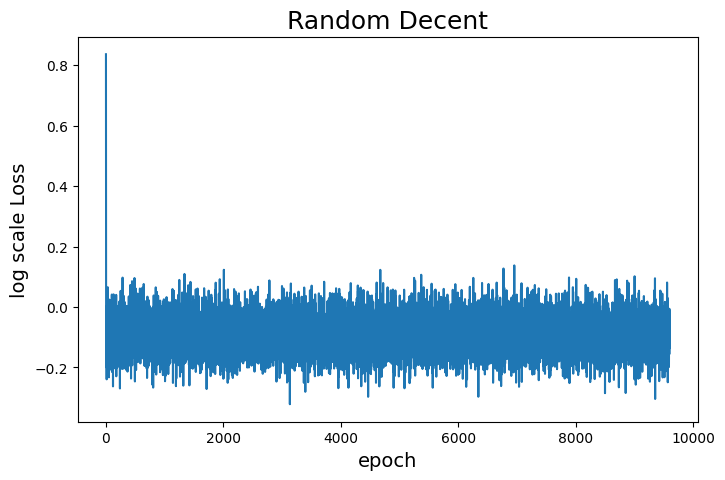

In [255]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.plot([i for i in range(len(model.history['Loss']))], np.log(model.history['Loss'])/np.log(10))
ax.set_ylabel('log scale Loss', fontsize = 14)
ax.set_xlabel('epoch', fontsize = 14)
ax.set_title('Random Decent', fontsize = 18)
plt.show()

In [258]:
model.HiddenLayers[0].order

array([3.68507204, 0.00801045, 1.22496016, 2.05345282, 3.39576259,
       0.88245601, 0.71141802, 0.00551549, 2.30426071, 4.0559377 ])

In [127]:
N = 8000
x = np.random.uniform(30, 10, (N, 10))
# w = np.abs(np.random.uniform(10, 1, (2,10)))
w = np.expand_dims(w[0], axis = 0)
w = np.tile(w, [N, 1, 1])
# y = np.random.uniform(10, 1, (100, 2))
y = np.matmul(w, np.expand_dims(x**2, axis = -1))[:,:,0]


IndexError: index 1 is out of bounds for axis 1 with size 1

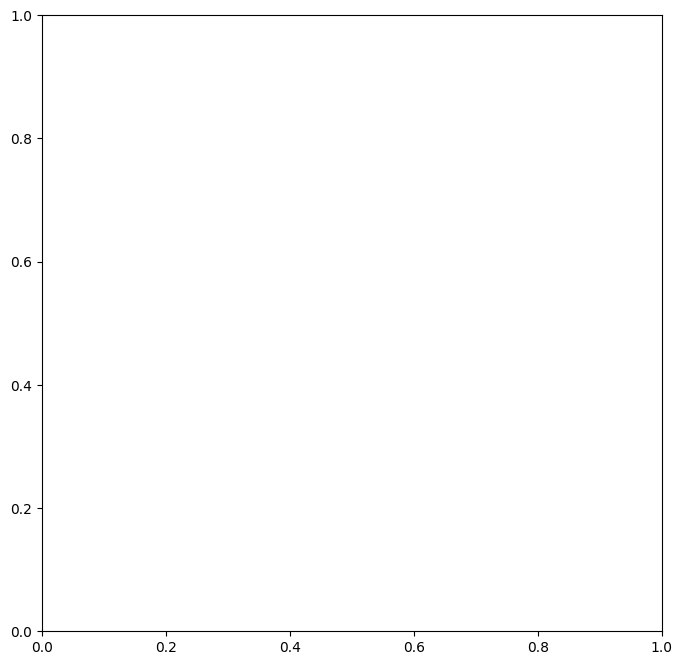

In [210]:
model.test_layer = -1
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
y_pre = model.predict(x)
# ax.hist(y[:,0], label = 'Target', bins = 100, histtype = 'step')
# ax.hist(y_pre[:,0], label = 'Predict', bins = 100, histtype = 'step')
ax.scatter(y[:,0], y[:, 1], label = 'Target', s = 5, alpha = 0.5)
ax.scatter(y_pre[:,0], y_pre[:, 1], label = 'Predict', s = 5, alpha = 0.5)
ax.set_title('Target Space')
ax.legend()
plt.show()

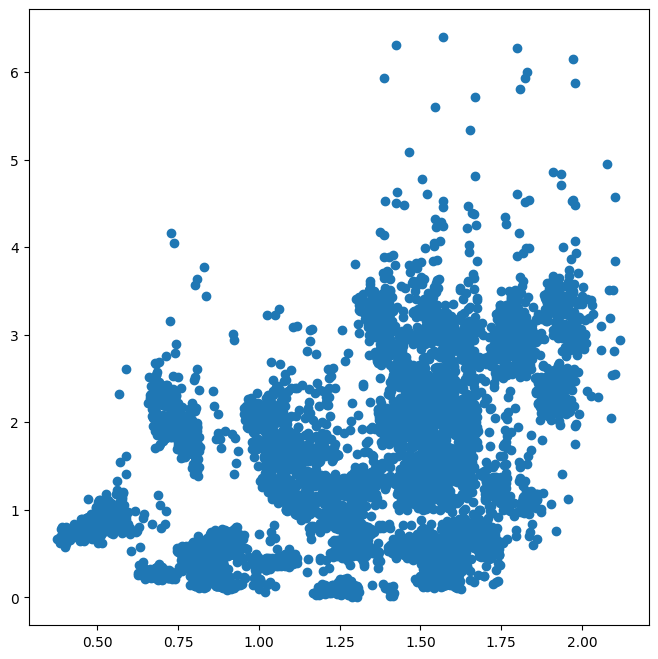

In [257]:
# for i in range(x.shape[-1]):
#     fig, ax = plt.subplots(1, 1, figsize = (8, 8))
#     ax.hist(x[:,i], histtype = 'step')
#     plt.show()
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
# ax.hist(y[:,0], histtype = 'step')
# ax.hist(y_pre[:,0], histtype = 'step')
ax.scatter(y_pre[:,0], y[:,0])
# ax.hist(, histtype = 'step')
plt.show()

In [116]:
model.HiddenLayers[0].mean

array([ 1.85127683, -0.10196703,  1.23531591,  2.72992032,  0.49412003,
       -0.44878666,  1.87513563,  0.64358303,  1.60995469, -0.36891512,
        1.11885962, -0.64495291,  1.50225286,  1.18805707, -0.60573047,
        1.23178013,  1.12378292,  0.17687252,  0.17459726,  0.13890773])